In [28]:
import  matplotlib.pyplot as plt
import numpy as np
import torch

# 提取数据集

shape of s: (10000, 2)


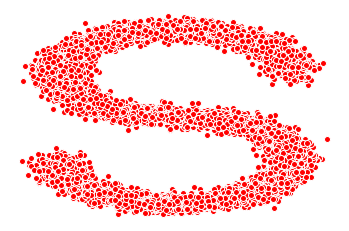

tensor([[-0.0290, -0.2133],
        [-0.0439, -0.2033],
        [ 0.0691, -0.1424],
        ...,
        [ 0.0804, -0.0259],
        [-0.1085,  0.1147],
        [-0.0920,  0.1406]])


In [29]:
from sklearn.datasets import make_s_curve # 使用sklearn中的方法生成数据集

s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data ,color='red',edgecolor='white')
ax.axis('off')
plt.show()
dataset = torch.Tensor(s_curve).float()
print(dataset)

# 取超参数的值
beta的定义依赖于paper DDPM
$$
\beta = 1 - \alpha
$$
此处并未学习超参数alpha，而是选择一组已经设定好的值

In [30]:
num_steps = 100 # 总时间步骤

betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)* (0.5e-2 - 1e-5) + 1e-5

alphas = 1-betas
alphas_bar = torch.cumprod(alphas,0) # 连乘
print(alphas_bar)
alphas_bar_p = torch.cat([torch.tensor([1]).float(),alphas_bar[:-1]],0) # 拼接 得到alpha(t-1)_bar
alphas_bar_sqrt = torch.sqrt(alphas_bar)
one_minus_alphas_bar_log = torch.log(1 - alphas_bar)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_bar)

tensor([1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9996, 0.9996, 0.9995, 0.9994, 0.9994, 0.9993, 0.9992, 0.9991,
        0.9990, 0.9988, 0.9987, 0.9985, 0.9983, 0.9981, 0.9979, 0.9977, 0.9974,
        0.9971, 0.9967, 0.9963, 0.9959, 0.9954, 0.9948, 0.9942, 0.9936, 0.9928,
        0.9920, 0.9911, 0.9901, 0.9890, 0.9878, 0.9865, 0.9851, 0.9836, 0.9819,
        0.9801, 0.9781, 0.9761, 0.9738, 0.9715, 0.9690, 0.9663, 0.9635, 0.9606,
        0.9576, 0.9544, 0.9511, 0.9477, 0.9442, 0.9406, 0.9370, 0.9332, 0.9294,
        0.9255, 0.9215, 0.9175, 0.9135, 0.9094, 0.9053, 0.9012, 0.8970, 0.8928,
        0.8886, 0.8844, 0.8802, 0.8760, 0.8718, 0.8676, 0.8634, 0.8592, 0.8550,
        0.8508, 0.8467, 0.8425, 0.8383, 0.8342, 0.8301, 0.8260, 0.8219, 0.8178,
        0.8138, 0.8097, 0.8057, 0.8017, 0.7977, 0.7937, 0.7898, 0.7858, 0.7819,
        0.7780])


# 确定扩散过程中任意时刻的采样值
$$
q(x_t|x_0) = x(t) \sim \N({x_t;\sqrt{\overline{\alpha_t}}*x_0,(1-{\overline{\alpha_t}})I)}
$$
基于x0得到任意时刻的xt

In [31]:
def q_x(x_0 ,t):
    noise = torch.randn_like(x_0) # noise 是从正态分布中生成的随机噪声
    return (alphas_bar_sqrt[t] * x_0 + one_minus_alphas_bar_sqrt[t] * noise)

# 演示原始数据加噪后的结果

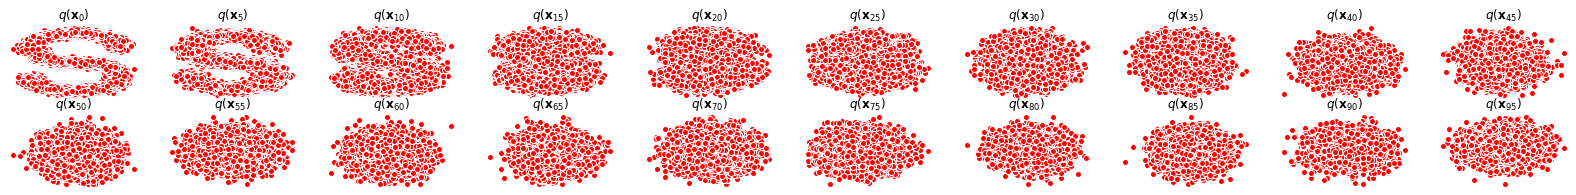

In [32]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

# 共有10000个点，每个点包含两个坐标
# 生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i // 10 # 向下取整
    k = i % 10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))# 生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

# 拟合逆扩散过程高斯分布

In [33]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__() # 父类初始化
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units), # 参数：（词典大小尺寸，维度）
                nn.Embedding(n_steps,num_units), # 词汇向量编码
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
#       x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t) # 将时间信息编码
            x = self.linears[2*idx](x) # 经过线性层
            x += t_embedding # 合并信息
            x = self.linears[2*idx+1](x) # 激活
            
        x = self.linears[-1](x)
        
        return x

# 损失函数

![algorithm](./algorithm_ddpm.jpg)

In [37]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    t = torch.randint(0,n_steps,size=(batch_size//2,)) # 生成一半batchsize的随机时刻t -> 降低重复率
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1) # 添加一维
    # print("t.shape:",t.shape)
    
    #x0的系数
    a = alphas_bar_sqrt[t]
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音eps
    e = torch.randn_like(x_0)
    
    #构造模型的输入
    x = x_0*a + e*aml
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x,t.squeeze(-1)) # 减少一个维度
    
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

# 逆扩散采样函数

In [38]:

def p_sample_loop(model ,shape ,n_steps,betas ,one_minus_alphas_bar_sqrt):
    # 从x[T]恢复x[T-1],x[T-2],……，x[0]
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x, i ,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq
 
def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    # 从x[t]采样时刻t-1的重构值
    t = torch.tensor(t)
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t] # 系数
    eps_theta = model(x,t)
    mean = (1/(1-betas[t]).sqrt()) * (x-(coeff * eps_theta))
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt() # 实验上，使用sqrt(beta[t])和原论文中的式子结果类似
    sample = mean + sigma_t * z
    return (sample)

# 模型训练

Training model...
tensor(0.6633, grad_fn=<MeanBackward0>)
tensor(0.3814, grad_fn=<MeanBackward0>)
tensor(0.3905, grad_fn=<MeanBackward0>)
tensor(0.4918, grad_fn=<MeanBackward0>)
tensor(0.3450, grad_fn=<MeanBackward0>)
tensor(0.3183, grad_fn=<MeanBackward0>)
tensor(0.3193, grad_fn=<MeanBackward0>)
tensor(0.3172, grad_fn=<MeanBackward0>)
tensor(0.3868, grad_fn=<MeanBackward0>)
tensor(0.9619, grad_fn=<MeanBackward0>)
tensor(0.2779, grad_fn=<MeanBackward0>)
tensor(0.4502, grad_fn=<MeanBackward0>)
tensor(0.3209, grad_fn=<MeanBackward0>)
tensor(0.2527, grad_fn=<MeanBackward0>)
tensor(0.2549, grad_fn=<MeanBackward0>)
tensor(0.3718, grad_fn=<MeanBackward0>)
tensor(0.4832, grad_fn=<MeanBackward0>)
tensor(0.2787, grad_fn=<MeanBackward0>)
tensor(0.4652, grad_fn=<MeanBackward0>)
tensor(0.4002, grad_fn=<MeanBackward0>)
tensor(0.2635, grad_fn=<MeanBackward0>)


<ipython-input-39-a2d357f1c5ab>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.3614, grad_fn=<MeanBackward0>)
tensor(0.3007, grad_fn=<MeanBackward0>)
tensor(0.3051, grad_fn=<MeanBackward0>)
tensor(0.3842, grad_fn=<MeanBackward0>)
tensor(0.2001, grad_fn=<MeanBackward0>)
tensor(0.3068, grad_fn=<MeanBackward0>)
tensor(0.4226, grad_fn=<MeanBackward0>)
tensor(0.2399, grad_fn=<MeanBackward0>)
tensor(0.3210, grad_fn=<MeanBackward0>)
tensor(0.2206, grad_fn=<MeanBackward0>)
tensor(0.4943, grad_fn=<MeanBackward0>)
tensor(0.2918, grad_fn=<MeanBackward0>)
tensor(0.2047, grad_fn=<MeanBackward0>)
tensor(0.3130, grad_fn=<MeanBackward0>)
tensor(0.4982, grad_fn=<MeanBackward0>)
tensor(0.1811, grad_fn=<MeanBackward0>)
tensor(0.5393, grad_fn=<MeanBackward0>)
tensor(0.2588, grad_fn=<MeanBackward0>)
tensor(0.2955, grad_fn=<MeanBackward0>)


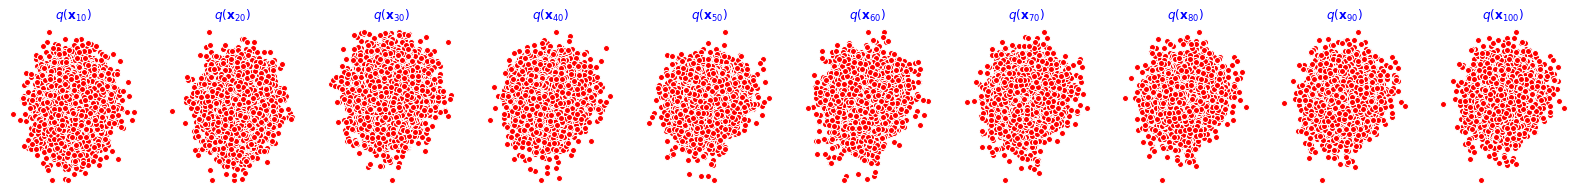

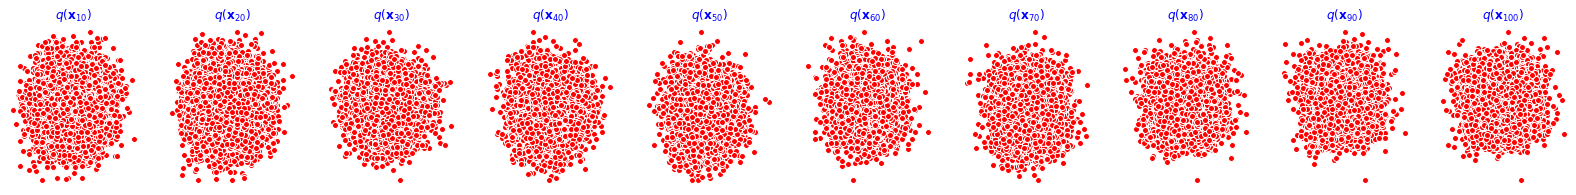

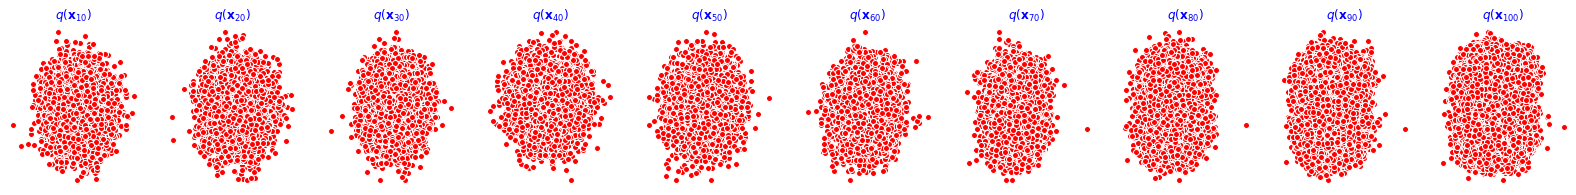

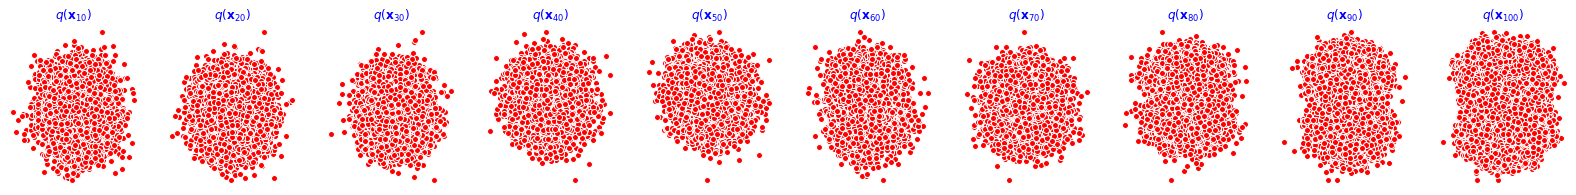

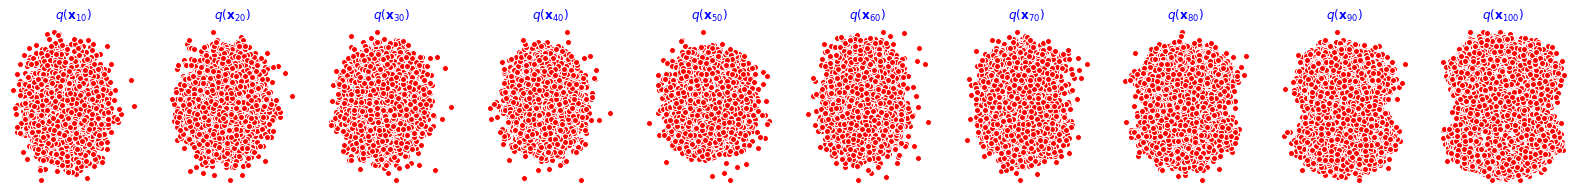

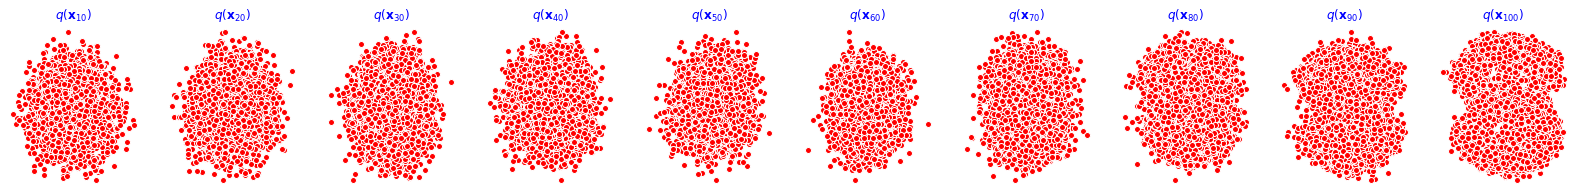

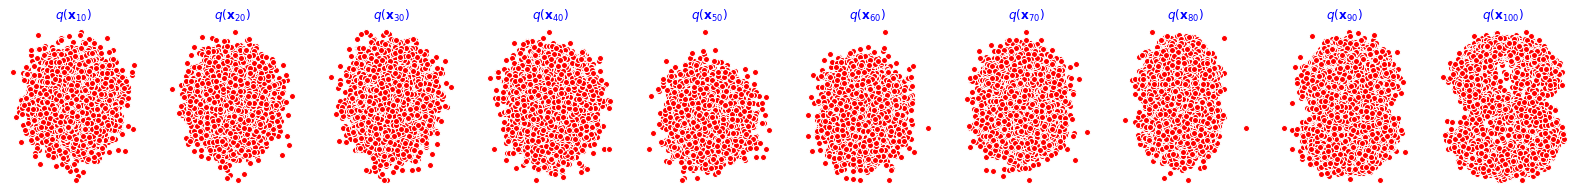

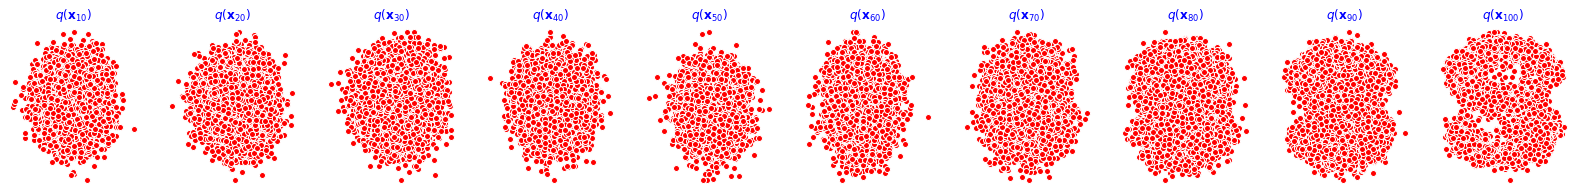

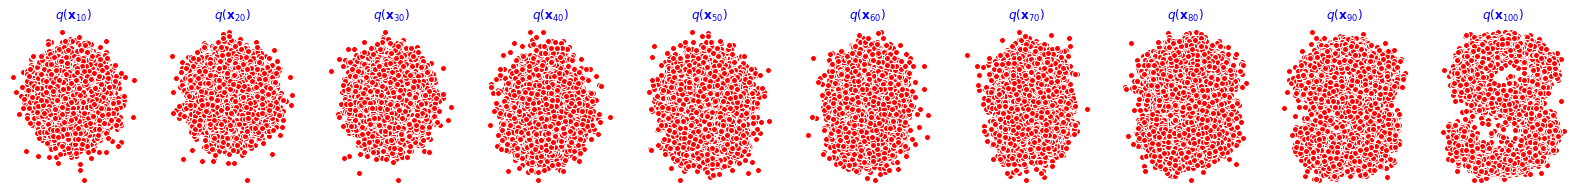

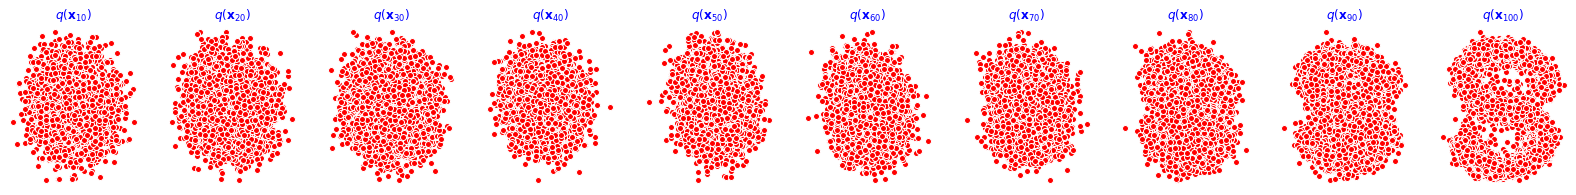

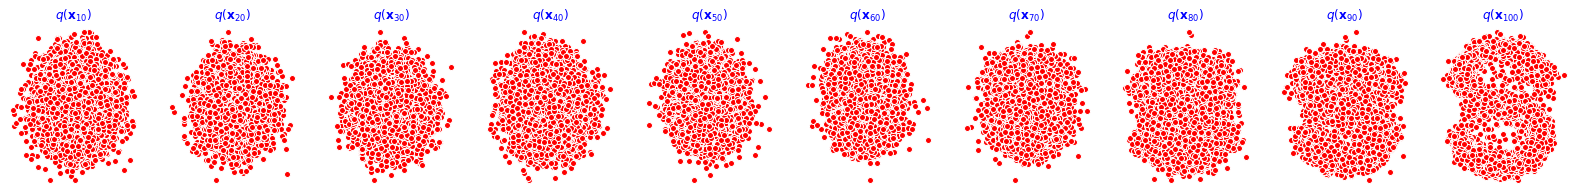

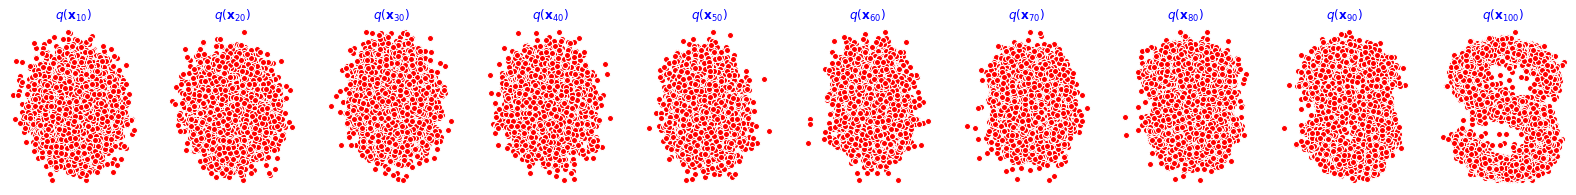

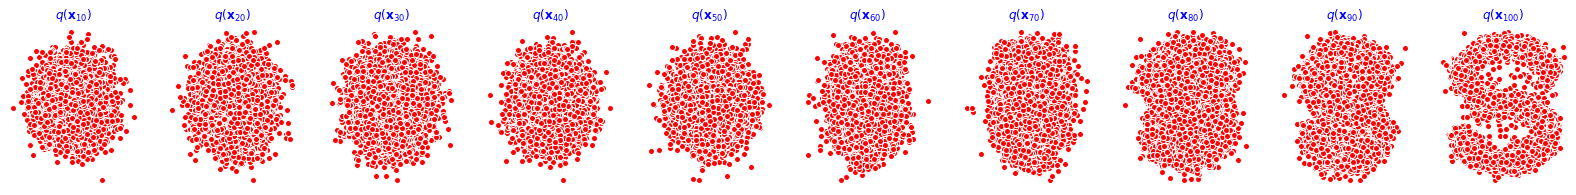

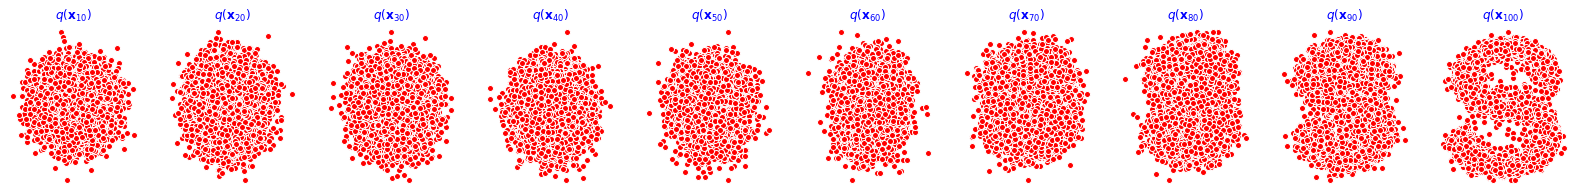

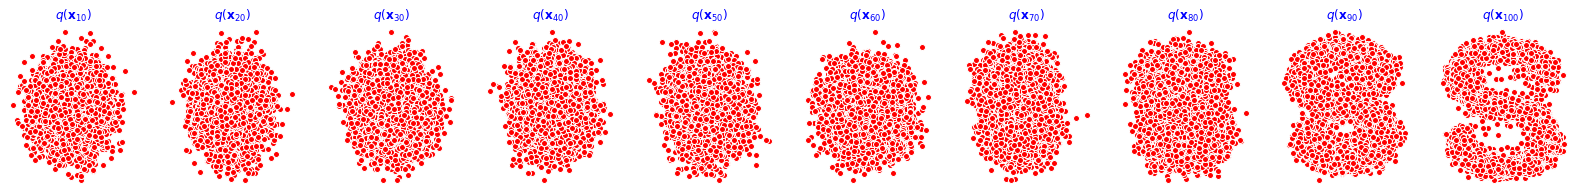

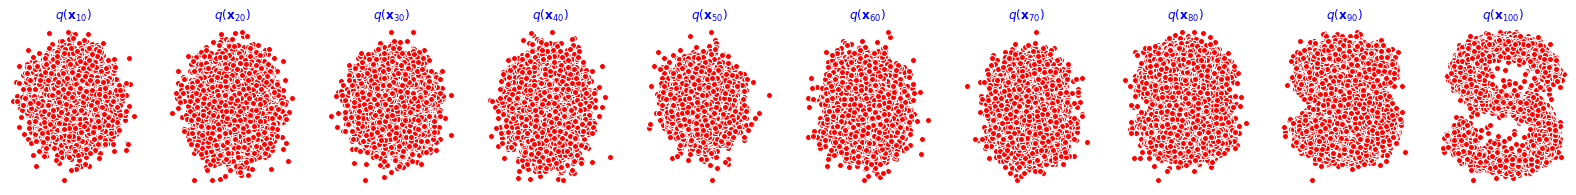

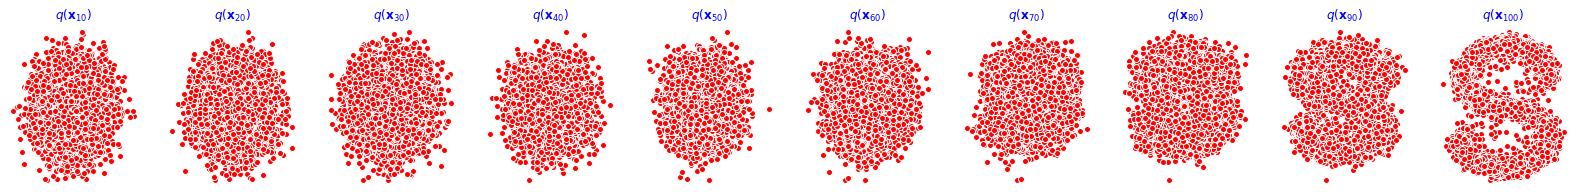

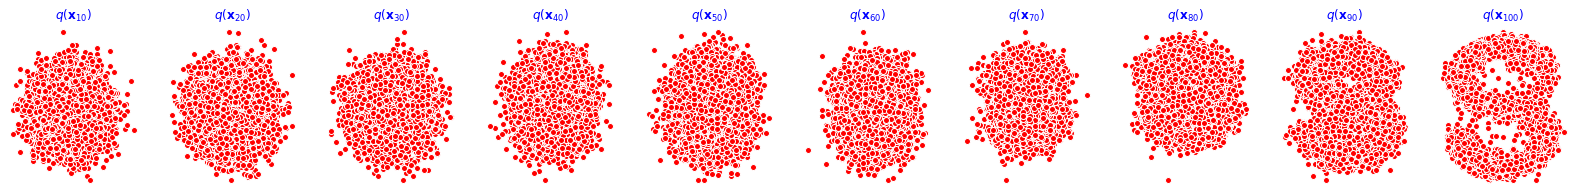

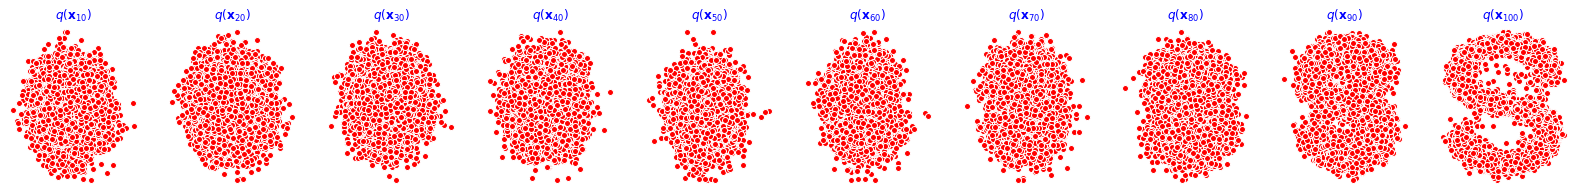

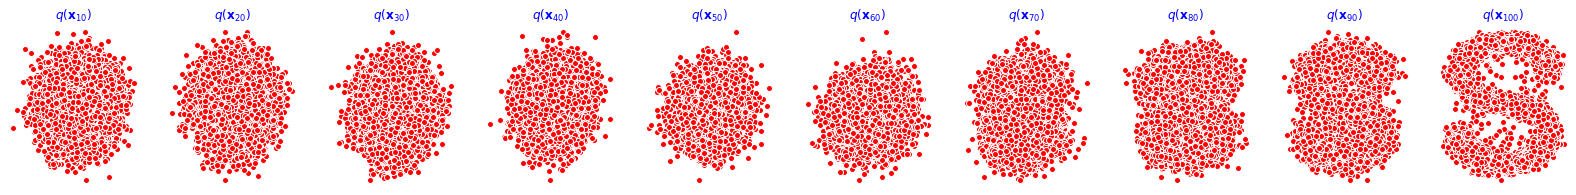

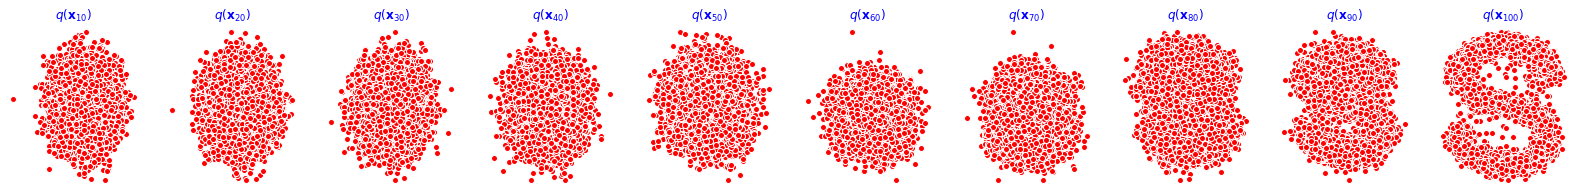

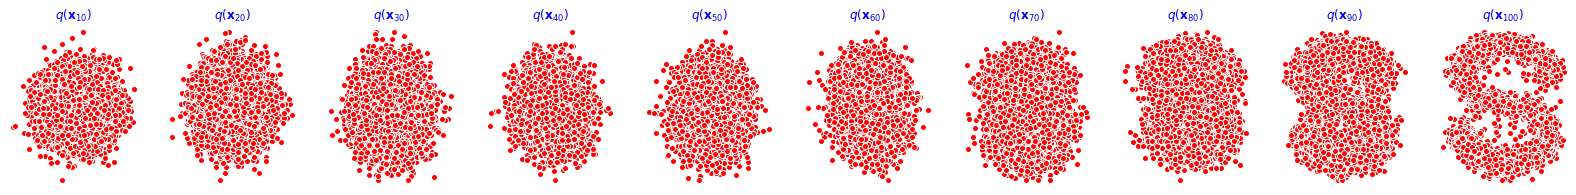

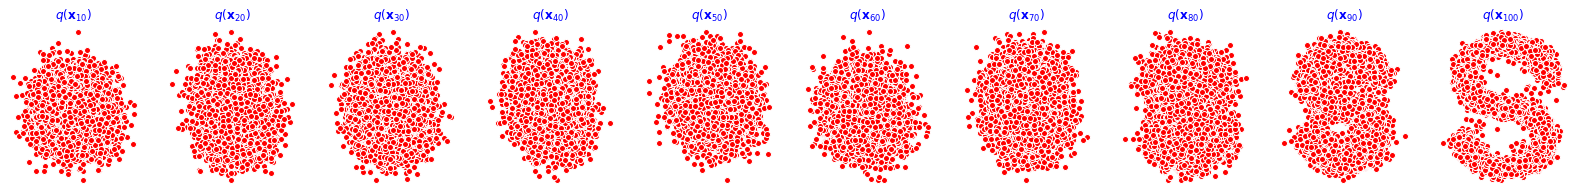

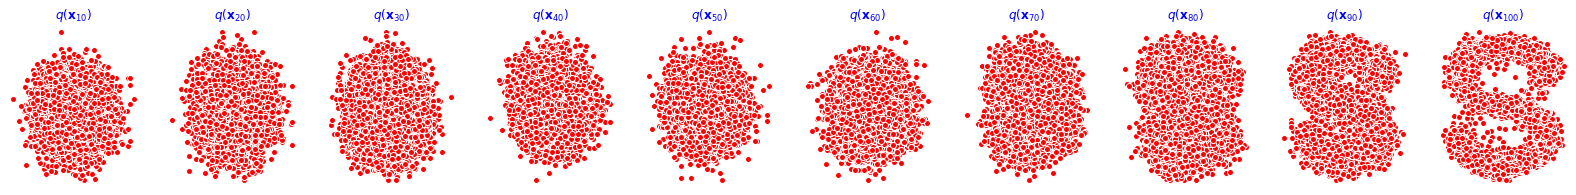

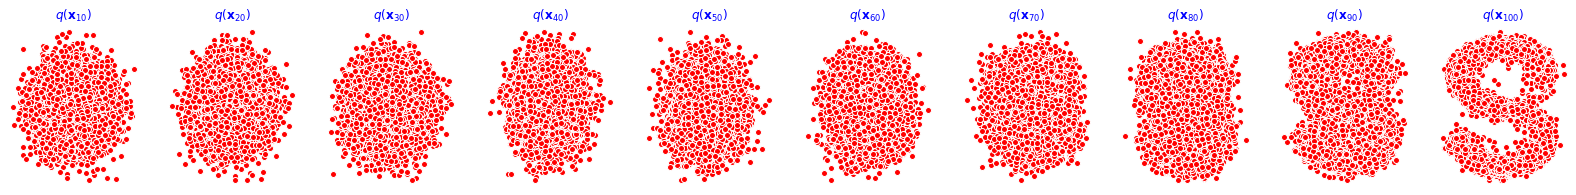

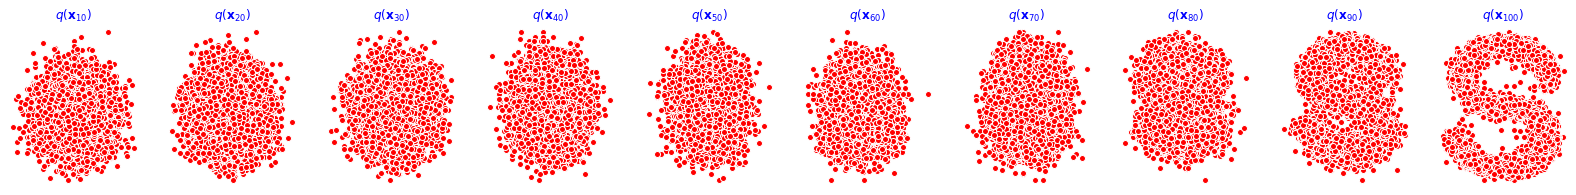

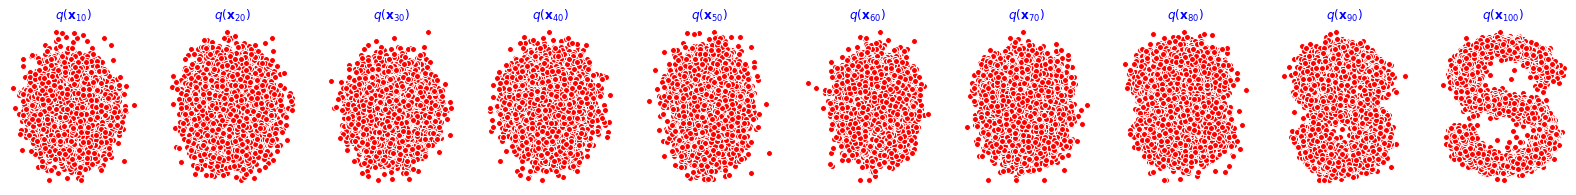

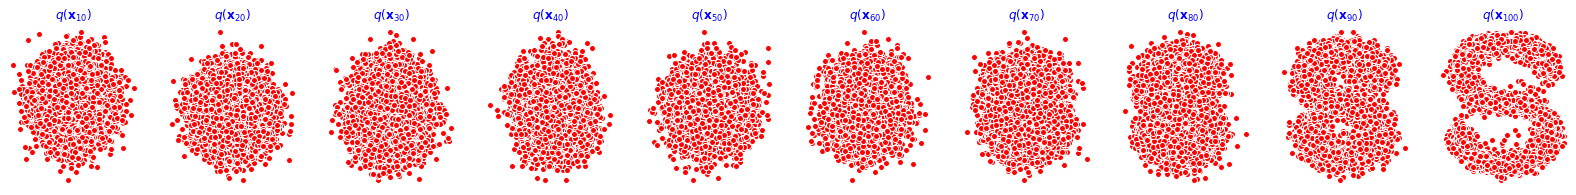

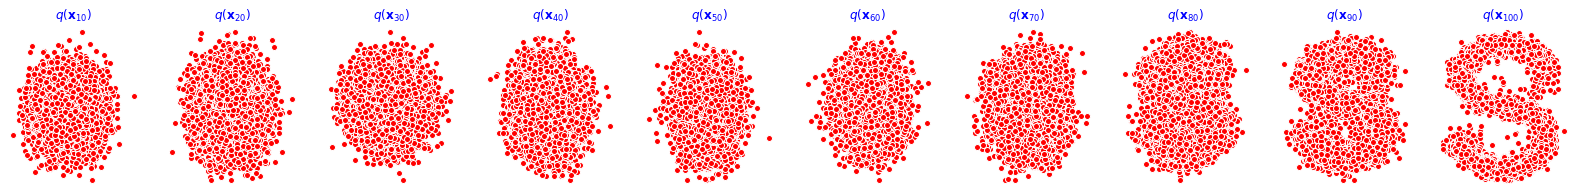

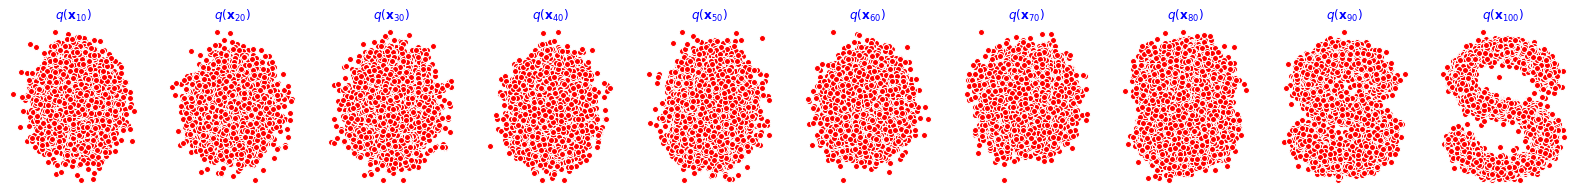

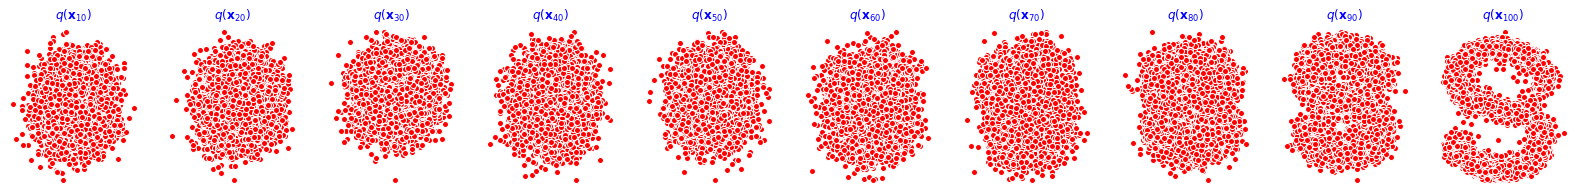

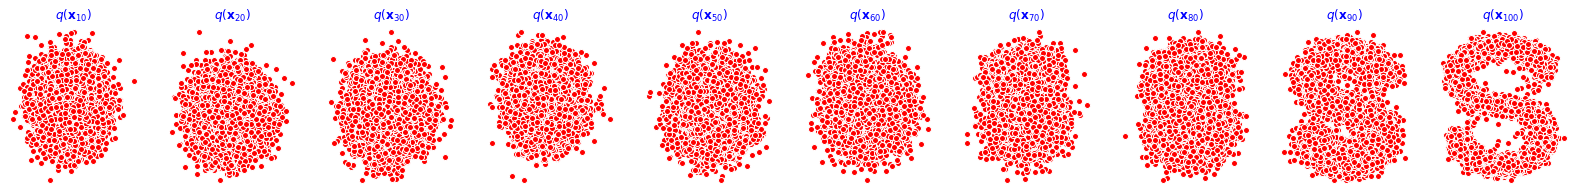

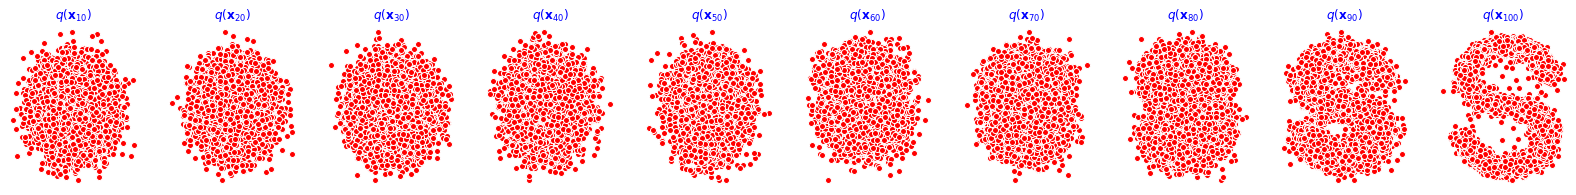

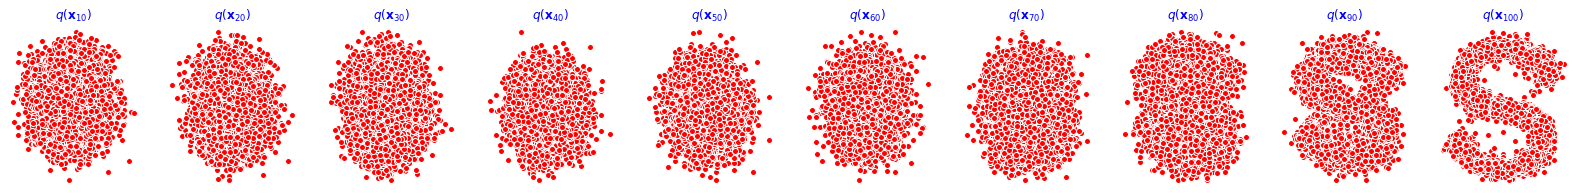

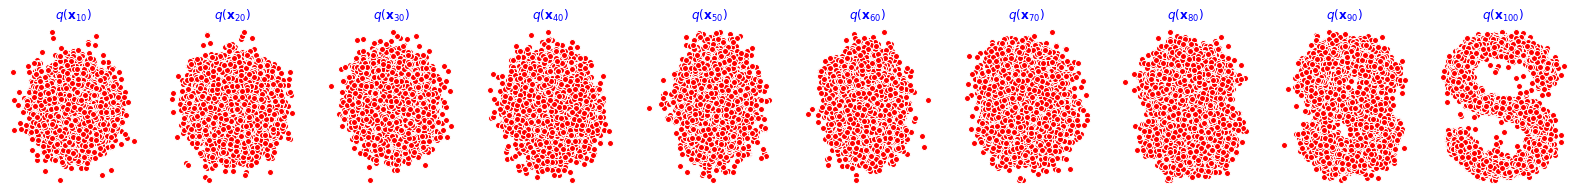

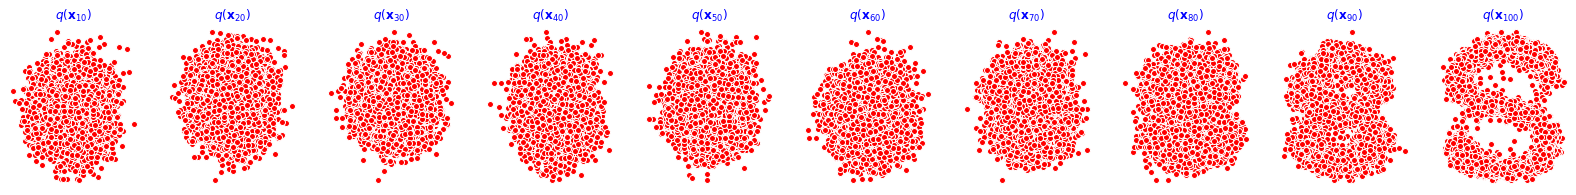

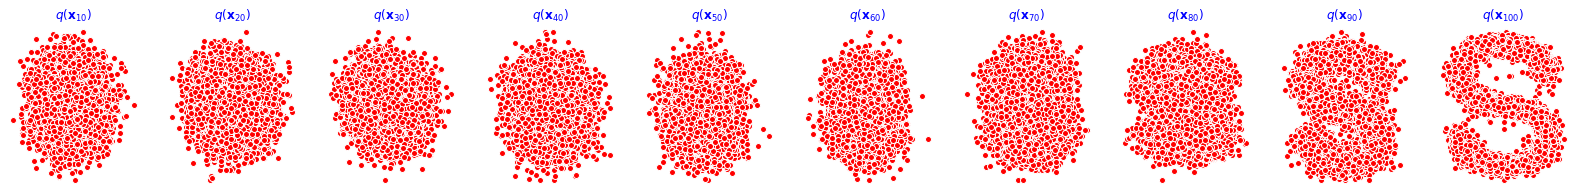

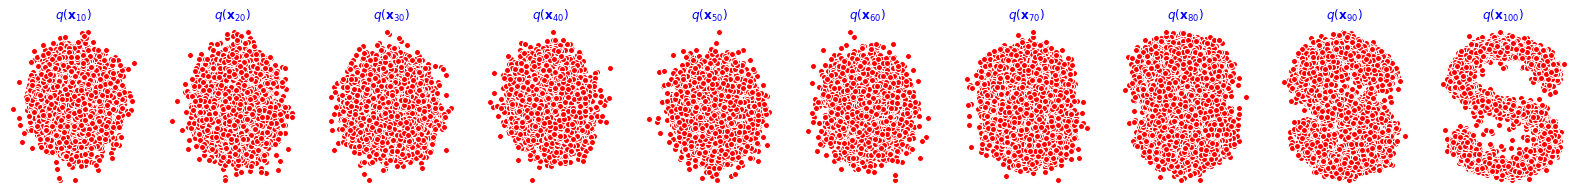

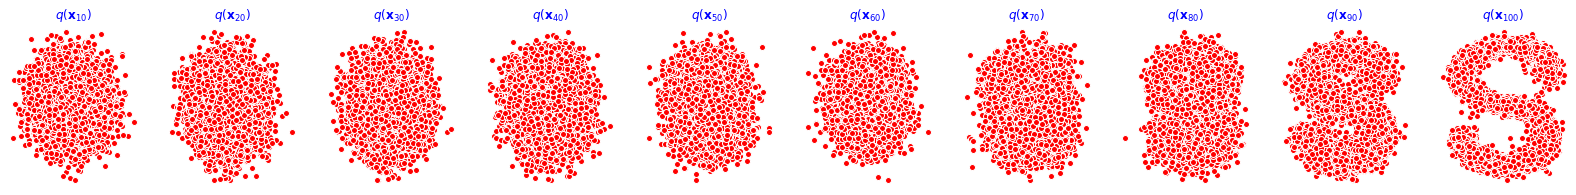

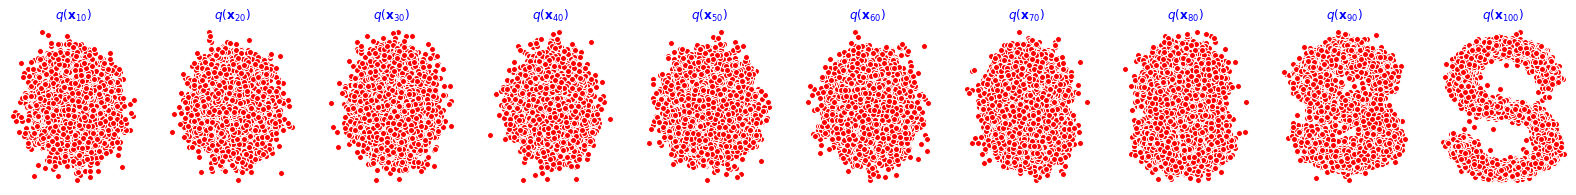

In [39]:
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)# 输入总共的步骤数
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad() # 初始化梯度为0
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.) # 解决梯度爆炸 限制参数的梯度
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        # 逆扩散采样
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            # 返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置
            # 不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

# test

In [26]:
x=torch.zeros(5,1,1,1)
print(x.shape)
x=x.unsqueeze(-1)
print(x.shape)
x=x.squeeze(-1)
print(x.shape)

torch.Size([5, 1, 1, 1])
torch.Size([5, 1, 1, 1, 1])
torch.Size([5, 1, 1, 1])
